In [12]:
import os
import pickle
# Helper libraries
import pandas as pd
import matplotlib as plt
import collections
from datetime import datetime
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize.treebank import TreebankWordTokenizer
from rouge import Rouge
import rouge
from w266_common import utils, vocabulary, tf_embed_viz, treeviz
from w266_common import patched_numpy_io
from tensor2tensor import problems
from tmp import load_doc, clean_lines, load_stories, split_story, write_story_highlight

Initially we need to load up the data, the data can be found at [CNN data link](https://drive.google.com/uc?export=download&id=0BwmD_VLjROrfTHk4NFg2SndKcjQ). We untar it in the same directory : ```tar xvf cnn_stories.tgz``` on the command line. After we load up the data, we separate out to the story and highlight portion and store it as a list of dictionaries.

In [13]:
# load stories
t = datetime.now()
directory = '../cnn/stories/'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))
print(datetime.now() - t)


Loaded Stories 92465
0:01:02.319076


In [14]:
# clean stories
t = datetime.now()

for example in stories:
    example['story'] = clean_lines(example['story'].split('\n'))
    example['highlights'] = clean_lines(example['highlights'])
    
print(datetime.now() - t)


0:01:15.018866


Now splitting to an array of story sentences and the corresponding highlight sentences we get :

In [15]:
t = datetime.now()
stories_list    = list(map(lambda s: s['story'], stories))
highlights_list = list(map(lambda s: s['highlights'], stories))
print(datetime.now() - t)


0:00:00.027292


In [4]:
mean_story_length = np.mean(list(map(lambda s: len(s), stories_list)))

In [5]:
mean_sentence_length_of_every_story = np.mean(list(map(lambda s: len(s), [s for t in stories_list for s in t])))

In [6]:
print("Mean length of story is {:.3f} sentences and the Mean sentence length of every story is {:.3f} charachters".format(mean_story_length, mean_sentence_length_of_every_story))

Mean length of story is 21.331 sentences and the Mean sentence length of every story is 174.355 charachters


Now separating the datasets to training, dev and test datasets :

In [16]:
def get_train_test_stories(stories, highlights, split=0.8, shuffle=False):
    """Generate train/test split for unsupervised tasks.

    Args:
      stories(list): list of stories
      split (double): fraction to use as training set
      shuffle (int or bool): seed for shuffle of input data, or False to just
      take the training data as the first xx% contiguously.

    Returns:
      train_sentences, test_sentences ( list(list(string)) ): the train and test
      splits
    """
    sentences = np.array(list(stories), dtype=list)
    highlights = np.array(list(highlights), dtype=list)
    fmt = (len(sentences), sum(map(len, sentences)))
    print("Loaded {:,} stories ({:g} sentences)".format(*fmt))

    if shuffle:
        rng = np.random.RandomState(shuffle)
        all_sents = list(zip(sentences, highlights))
        rng.shuffle(all_sents)
        sentences, highlights = zip(*all_sents)
        # rng.shuffle(sentences)  # in-place
        # rng.shuffle(highlights)  # in-place
    split_idx = int(split * len(sentences))
    test_dev_split_idx = int((len(sentences) - split_idx)/2)+ split_idx
    print(split_idx, test_dev_split_idx)
    train_stories = sentences[:split_idx]
    dev_stories = sentences[split_idx:test_dev_split_idx]
    test_stories = sentences[test_dev_split_idx:]
    train_highlights = highlights[:split_idx]
    dev_highlights = highlights[split_idx:test_dev_split_idx]
    test_highlights = highlights[test_dev_split_idx:]
    
    
    fmt = (len(train_stories), sum(map(len, train_stories)))
    print("Training set: {:,} stories ({:,} sentences)".format(*fmt))
    fmt = (len(dev_stories), sum(map(len, dev_stories)))
    print("Dev set: {:,} stories ({:,} sentences)".format(*fmt))
    fmt = (len(test_stories), sum(map(len, test_stories)))
    print("Test set: {:,} stories ({:,} sentences)".format(*fmt))

    return train_stories, dev_stories, test_stories, train_highlights, dev_highlights, test_highlights


In [17]:
train_stories_list, dev_stories_list, test_stories_list, train_highlights_list, dev_highlights_list, test_highlights_list \
= get_train_test_stories(stories_list , highlights_list, split=0.9, shuffle=42)

Loaded 92,465 stories (1.97239e+06 sentences)
83218 87841
Training set: 83,218 stories (1,774,282 sentences)
Dev set: 4,623 stories (99,520 sentences)
Test set: 4,624 stories (98,592 sentences)


In [9]:
#train_sentences = [item for sublist in train_story_sentences_list for item in sublist]

In [7]:
t = datetime.now()
all_sentences = [item for sublist in stories_list for item in sublist]
print(datetime.now() - t)


0:00:00.215997


In [8]:
t = datetime.now()
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
x_tokens = [tokenizer.tokenize(ts) for ts in all_sentences]
print("Number of tokens is",len(x_tokens))
print(datetime.now() - t)

Number of tokens is 1972394
0:04:44.931964


Following steps are shown below :
1> Get the train_sentences,
2> Combine that with the brown corpus sents 
3> use that to form the count vectorizer
4> Run the baseline on the test_set 

In [11]:
t = datetime.now()
corpus = utils.get_corpus("brown")
x_tokens_flat= [item for sublist in x_tokens for item in sublist]
print(datetime.now() - t)

[nltk_data] Downloading package brown to /Users/fjlind8/nltk_data...
[nltk_data]   Package brown is already up-to-date!
0:00:14.478372


In [13]:
x_tokens_flat[:20]

['its',
 'official',
 'us',
 'president',
 'barack',
 'obama',
 'wants',
 'lawmakers',
 'to',
 'weigh',
 'in',
 'on',
 'whether',
 'to',
 'use',
 'military',
 'force',
 'in',
 'syria',
 'obama']

In [12]:
def combine_vocab(tokenList, corpus):
    token_feed = [utils.canonicalize_word(w) for w in tokenList]
    print(len(token_feed))
    token_feed.extend([utils.canonicalize_word(w) for w in corpus.words()])
    print(len(token_feed))
    return token_feed

In [13]:
t = datetime.now()
combined_words = combine_vocab(x_tokens_flat, corpus)
print(datetime.now() - t)

59195796
60356988
0:04:09.042014


In [14]:
t = datetime.now()
vocab = utils.build_vocab(combined_words, V=None)
print("Vocabulary size: {:,}".format(vocab.size))
print(datetime.now() - t)

Vocabulary: 333,971 types
Vocabulary size: 333,971
0:04:50.770851


In [15]:
sents_list = [" ".join(sent) for sent in corpus.sents()]

In [16]:
all_train_sentences = [item for sublist in train_stories_list for item in sublist]


In [17]:
combined_list = sents_list +  all_train_sentences

In [18]:
t = datetime.now()
count_vect = CountVectorizer(preprocessor=utils.canonicalize_word, stop_words={'English'})
count_vect = count_vect.fit(combined_list)
print(datetime.now() - t)


0:01:29.587305


In [26]:
type(train_stories_list)

numpy.ndarray

In [19]:
t = datetime.now()
#freq_term_matrix = count_vect.transform(train_stories_list[0])
freq_term_matrix = count_vect.transform(all_train_sentences)
print(datetime.now() - t)

0:01:22.391710


In [20]:
t = datetime.now()
tfidf = TfidfTransformer(norm = 'l2')
tfidf.fit(freq_term_matrix)
print(datetime.now() - t)


0:00:00.396115


In [21]:
#story_freq_term = count_vect.transform(train_stories_list[0])
#^ is freq_term_matrix
t = datetime.now()
story_tfidf_matrix = tfidf.transform(freq_term_matrix)
print(datetime.now() - t)


0:00:05.542550


In [ ]:
t = datetime.now()
story_dense = story_tfidf_matrix.todense()
print(datetime.now() - t)


In [ ]:
doc_matrix = story_dense.tolist()[0]

In [25]:
NOUNS = ['NN', 'NNS', 'NNP', 'NNPS']
def rank_sentences(sents, doc_matrix, feature_names, top_n=4):
    sentences = [nltk.word_tokenize(sent) for sent in sents]
    sentences = [[w for w in sent if nltk.pos_tag([w])[0][1] in NOUNS]
                  for sent in sentences]
    tfidf_sent = [[doc_matrix[feature_names.index(w.lower())]
                   for w in sent if w.lower() in feature_names]
                 for sent in sentences]
    #print(tfidf_sent)

    # Calculate Sentence Values
    doc_val = sum(doc_matrix)
    sent_values = [sum(sent) / doc_val for sent in tfidf_sent]
    scored_sents = np.array(sent_values) #+ np.array(similarity_scores)

    # Apply Position Weights
    ranked_sents = [sent*(i/len(sent_values))
                    for i, sent in enumerate(sent_values)]

    ranked_sents = [pair for pair in zip(range(len(sent_values)), sent_values)]
    ranked_sents = sorted(ranked_sents, key=lambda x: x[1] *-1)

    return ranked_sents[:top_n]

In [26]:
rank = rank_sentences(train_stories_list[0:1], doc_matrix, count_vect.get_feature_names())

In [27]:
print(rank)

[(0, 0.5299752277398218), (32, 0.23171045158734266), (2, 0.1639256901597589), (26, 0.1639256901597589)]


In [34]:
def get_base_line_rouge_score(test_stories_list, test_highlights_list, n=4):
    t = []
    h = []
    r = []
    for i in range(len(test_stories_list)):
        t.append(' '.join(test_stories_list[i][:n]))
        h.append(' '.join(train_highlights_list[i]))
        rouge = Rouge()
        rg_score = rouge.get_scores(t[i],h[i])
        r.append(rg_score)
    
        #print(rouge.get_scores(t[i],h[i]))
        if(rg_score[0]['rouge-1']['r'] > 0.68):
            print(i)
            print(t[i]+'\n\n'+h[i])
            print("\n\ntfidf_score: ",tfidf_s[i])
    return r

In [35]:
r_base_line = get_base_line_rouge_score(test_stories_list, test_highlights_list)

In [36]:
def rouge_scores_to_df(rouge_scores, filename):
    '''
    rouge_scores: result from rouge scoring function
    filename: name of file, excluding extension
    '''
    score_lists = []

    for score in rouge_scores:
        scores = []

        for rouge_type in score[0].values():
            for score_type in rouge_type.values():
                scores.append(score_type)

        score_lists.append(scores)
        
    df = pd.DataFrame(score_lists, columns = ['rouge_1_f', 'rouge_1_p', 'rouge_1_r',
                                              'rouge_2_f', 'rouge_2_p', 'rouge_2_r',
                                              'rouge_l_f', 'rouge_l_p', 'rouge_l_r'])
    
    df.to_csv(filename + '.csv')
    
    return df
    

In [38]:
df_base_line_rouge = rouge_scores_to_df(r_base_line, 'BaseLineRouge')

In [3]:
# df_base_line_rouge = pd.read_csv('BaseLineRouge.csv')


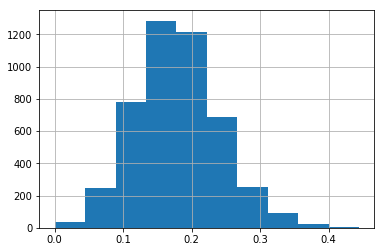

In [39]:
df_base_line_rouge.rouge_1_r.hist()


In [28]:
ul = df_base_line_rouge.rouge_1_r
sl = sorted(range(len(ul)), key = lambda k: ul[k], reverse = True)
sl[0:10], sl[-10:]
# ul[4176]

([4176, 1352, 611, 4004, 4382, 794, 2129, 4232, 878, 2015],
 [1635, 4396, 1707, 1721, 2743, 2896, 3766, 4417, 4538, 4555])

In [26]:
# Top 10
[(test_stories_list[i][0:4], test_highlights_list[i]) for i in sl[0:10]]

[(['cnns piers morgan calls the onscreen relationship between the kings speech actors colin firth and geoffrey rush one of the great bromances weve ever seen in the movies',
   'firth with his costars geoffrey rush and helena bonham carter joins morgan tonight at to talk about their movie which leads the oscar race and has dominated the awards shows so far all three lead performers and the film itself are nominated for academy awards scheduled to be presented february in hollywood when morgan asked firth to describe rush the actor said i would describe him as my geisha girl',
   'geoffrey rush appeared via satellite from australia firth also called rush one of the most thrilling actors ive ever worked with and ive seen him be howlingly funny and absolutely heartbreaking hes got the whole spectrum covered',
   'we have been texting one another at various points to try and keep sane about the madness thats gone on around the film said rush and we do tend to refer to each other as abelard

In [29]:
# Bottom 10
[(test_stories_list[i][0:4], test_highlights_list[i]) for i in sl[-10:]]

[(['cnn student news may',
   'download pdf maps related to todays show',
   'london england libya new york city',
   'transcript'],
  ['explore the special relationship between the us and uk',
   'find out how living conditions are affected by war in libya',
   'discover what information will be displayed on new fuel labels',
   'use the daily discussion to help students understand todays featured news stories']),
 (['cnnmilan has moxy while much of europe is painted blu',
   'jaz in the city is playing in amsterdam come september',
   'even increases the odds of a good nights sleep while tune is in harmony with scaleddown budgets',
   'and then theres the vibrant vib and a new venue venu soon arriving in dubai'],
  ['from blu to vib the latest crop of hotel names features misspellings and unexpected word usage',
   'its part of the hospitality industrys aim to target millennial psychographic and trademark their names',
   'w hotels by starwood was among the pioneers of this strategy 

In [53]:
df_base_line_rouge.mean()

rouge_1_f    0.102921
rouge_1_p    0.074681
rouge_1_r    0.178708
rouge_2_f    0.004624
rouge_2_p    0.003190
rouge_2_r    0.009226
rouge_l_f    0.057268
rouge_l_p    0.052593
rouge_l_r    0.127309
dtype: float64

In [55]:
df_base_line_rouge.median()

rouge_1_f    0.101449
rouge_1_p    0.072119
rouge_1_r    0.176471
rouge_2_f    0.000000
rouge_2_p    0.000000
rouge_2_r    0.000000
rouge_l_f    0.055650
rouge_l_p    0.051282
rouge_l_r    0.125000
dtype: float64

In [31]:
mean_r1 = np.mean(list(map(lambda s: s[0]['rouge-1']['r'], r_base_line)))

In [32]:
mean_r2 = np.mean(list(map(lambda s: s[0]['rouge-2']['r'], r_base_line)))

In [33]:
mean_rl = np.mean(list(map(lambda s: s[0]['rouge-l']['r'], r_base_line)))

In [34]:
print("The mean Rouge-1, Rouge-2 and Rouge-L scores for recall are", mean_r1, mean_r2, mean_rl)

The mean Rouge-1, Rouge-2 and Rouge-L scores for recall are 0.17776397659594873 0.00896506529925776 0.1264831982497302


In [41]:
def get_rouge_score(test_stories_list, test_highlights_list, count_vect, tfidf, doc_matrix, n=4):
    t = []
    h = []
    tfidf_s = []
    r = []
    len_stories = len(test_stories_list)
    for i in range(len_stories):
        story_freq_term = count_vect.transform(test_stories_list[i])
        story_tfidf_matrix = tfidf.transform(story_freq_term)
        story_dense = story_tfidf_matrix.todense()
        doc_matrix = story_dense.tolist()[0]
        rank = rank_sentences(test_stories_list[i], doc_matrix, count_vect.get_feature_names(), n)
        t.append(' '.join([test_stories_list[i][id[0]] for id in rank]))
        tfidf_s.append([id[1] for id in rank])
        h.append(' '.join(test_highlights_list[i]))
        rouge = Rouge()
        rg_score = rouge.get_scores(t[i],h[i])
        r.append(rg_score)

        #print(rouge.get_scores(t[i],h[i]))
        if(rg_score[0]['rouge-1']['r'] > 0.68):
            print(i)
            print(t[i]+'\n\n'+h[i])
            print("\n\ntfidf_score: ",tfidf_s[i])
    return r

In [42]:
r_score = get_rouge_score(test_stories_list, test_highlights_list, count_vect, tfidf, doc_matrix, n=4)

0
minneapolis minnesota cnn the first caller to reach reported in a calm voice that gave no hint to the calamity that awaited a bridge down over the river four minutes later just before pm wednesday sgt ed nelson and two fellow police officers were among the first to arrive at the south side of the interstate bridge that rose feet above the mississippi river the trio wasted no time they split up leaving one officer on the road to direct arriving first responders while nelson and a fellow officer ditched their gunbelts and their radios and clambered aboard a span of the bridge that had tumbled to the river carrying a stillundetermined number of vehicles and people with it i dont think anybody quite expected the scene we encountered he said at a news conference featuring first responders it was utter chaos at that time bridge smoking dust in the air we knew it was a bad very bad situation

sgt ed nelson and two fellow police officers were among first to arrive nelson it was utter chaos a

105
a police chief from southeastern new hampshire who planned to retire in a few days has been shot to death while trying to execute a search warrant authorities said friday during a news conference friday delaney was asked why a police chief would be part of a dangerous mission so close to his retirement he did not answer the question directly but said all the officers involved were part of a drug investigation chief michael maloney of the police department in greenland a town of about was killed in a shooting that wounded four other officers on thursday night at a home in the community said attorney general michael delaney greenland is just south of the city of portsmouth its police force has members the town says on its website

the police chief in greeland new hampshire has been shot to death he planned to retire in a few days greenland is a town people located just south of portsmouth this is a tragedy for our community official says


tfidf_score:  [0.5319364856280271, 0.1253730

171
two men who have been together for years have become the first couple to obtain a samesex marriage since it became legal in argentina on july alex freyre and jose maria di bello were married in tierra del fuego at the southern tip of argentina in december they are believed to be the first samesex couple to be married in latin america argentina became the first latin american country to legalize samesex marriage when lawmakers in the senate passed the bill this month after hours of debate the bill had already passed the lower chamber of congress they were not the first samesex couple to be married in the nation just the first since the federal law was enacted

argentina is the first latin american nation to allow samesex marriage the federal law was enacted july the legality of samesex marriage had been determined at the local and state levels another couple celebrated a samesex marriage in december


tfidf_score:  [0.3913339988542237, 0.14922741231125744, 0.14922741231125744, 0.099

243
some travelers sleepily making their way through airport security in atlanta sunday morning got a startling wakeup a gun detected in a carryon at a checkpoint at hartsfieldjackson international airport was accidentally fired by an investigating officer around am sunday according to a police report transportation security administration screeners reported the gun to atlanta police officer nj phillips the officer wrote in an atlanta police department report the guns owner was telling phillips how to clear the loaded magnum revolver when it was accidentally discharged phillips reported the weapon was pointed down towards the screening table the guns owner richard popkin of kathleen georgia told phillips he didnt realize the gun was still in his bag according to the police report popkin said he originally intended to pack the bag in his checked luggage but he removed it because he was concerned about the weight limit for his checked bag according to the report tsa officers have discove

285
five us soldiers facing murder charges in the deaths of three afghan civilians earlier this year have now been charged with conspiracy to commit premeditated murder and seven more soldiers have been charged in connection with the probe into the incidents charges were also filed against seven other soldiers from the stryker brigade the military said wednesday but none involve murder or conspiracy to commit murder the five facing murder charges are pfc andrew holmes of boise idaho spc adam winfield of cape coral florida spc michael wagnon of las vegas nevada spc jeremy morlock of wasilla alaska and staff sgt calvin gibbs of billings montana they are from the stryker brigade in june the five were charged with murder holmes was accused of killing afghan civilian gul mudin in january with a grenade and rifle winfield is accused of killing civilian mullah adahdad in may in a similar manner wagnon is accused of shooting to death marach agha in february

the case stems from the killing of 

335
arnold schwarzenegger said he blames no one but himself for the breakup of his marriage to maria shriver whom he described as the only true love of his life shriver filed for divorce last year shortly after schwarzenegger acknowledged that he fathered a child outside marriage with the familys longtime housekeeper he said he still hopes to win shriver back i love my kids dearly and i love maria she has been truly the only love that ive ever had and thats what is so pitiful about it he said describing her as extraordinary and the most perfect wife all of a sudden from one day to the next the personal life totally crashed and i wiped out everything you know that i had i mean the thing that i cherished the most was my personal life was my marriage and was my family i always thought that it was one of my greatest accomplishments schwarzenegger said

arnold schwarzenegger opens up about the affair with his familys housekeeper the former governor says he still loves maria shriver and want

429
the death toll from last months landslide in rural washington state has risen to the snohomish county medical examiners office said monday of the recovered bodies have been identified the medical examiners office on monday released the name bill l spillers of arlington that count is up from which was the number given late last week twelve people are still missing the county sheriffs office said a square mile of wet earth and rock rushed into the outskirts of the town of oso in the north cascade mountains on march

people still are missing authorities say landslide happened in the north cascade mountains on march of bodies recovered have been identified


tfidf_score:  [0.6612652955787244, 0.1766705406059972, 0.11778036040399815, 0.0]
437
moscow cnna russian politician behind a controversial antigay propaganda law has been caught up in a social media storm in which he is pictured in a photograph of two women kissing vitaly milonov was on an aeroflot flight from moscow to st petersbu

491
one person died and at least seven others were injured sunday after a threealarm fire broke out in a new york city highrise authorities said fire crews gained control of the blaze which began on the floor of the highrise in midtown manhattan around noon according to new york city fire department spokesman danny glover the fire was ruled accidental and was caused by pieces of electrical equipment that were plugged into a power strip through several extension cords frank dwyer a fire department spokesman said monday fire crews received a call around am alerting them to the fire

new fire is ruled accidental caused by electrical equipment in a power strip daniel mcclung died after being trapped in a stairwell a spokesman says firefighters contained the fire around noon it broke out on the floor of highrise seven others had injuries one of them was sent to a hospital


tfidf_score:  [0.49341086698145226, 0.252009785213898, 0.1008039140855592, 0.1008039140855592]
494
italian champions i

527
embers from fireworks at magic kingdom ignited a small fire at disney worlds latest ride the seven dwarfs mine train on saturday night the nightly fireworks had just ended when embers landed on the building outside the attraction about pm igniting the fire the spokeswoman said the fire was quickly put out and no one was hurt a disney spokeswoman said passengers on the ride were able to get off safely and no one was evacuated she said

the fire was quickly put out and no one was hurt disney said passengers on the train were able to get off safely the ride reopened about an hour later


tfidf_score:  [0.6496971588323742, 0.1590015084430472, 0.10600100562869813, 0.053000502814349065]
533
the body found in a washington dc park is that of a man who was suspected of abducting an girl police said tuesday it appears the body has been dead for about hours dc police chief cathy lanier told reporters tuesday adding that the cause of death was suicide the case took on new urgency when police d

551
small portable sleep tents for infants and small children may pose a safety hazard prompting the consumer product safety commission and kidco inc to issue a voluntary recall of more than peapod and peapod plus travel beds the safety commission said the tents have a zippered side and an inflatable air mattress that fits into a zippered pocket underneath the floor of the tent the tents fold into a round shape and come with a fabric bag for storage and transport the recall was prompted in part after a report that a boy in new york was found dead last year with his face pressed against the side wall of the tent the cause of death was not determined according to the safety commission the safety commission said babies can potentially roll off the edge of the inflatable air mattress and become trapped between the mattress and the fabric sides of the tent and suffocate

peapod and peapod plus travel beds subject to voluntary recall a child was found dead with his face pressed against the w

589
in an abrupt a colorado soldier who tried to blame his identical twin brother for sex crimes pleaded guilty tuesday to those same charges there is no evidence to suggest that the twin brother of aaron lucas was in any way responsible for these crimes said prosecutor jennie darby aaron gregory lucas pleaded guilty to four counts of sexual assault on a child three counts of enticement two counts of indecent exposure and one count of kidnapping according to a spokeswoman for the judicial district attorneys office in colorado springs colorado a judge in el paso county ruled this month that lucas would be allowed to name his twin brother brian lucas as a suspect in his defense

new defendants attorney reportedly says client wanted to do the right thing aaron lucas pleads guilty to four counts of sexual assault on a child a judge had ruled that he could name his brother as a suspect in his defense prosecutor no evidence to suggest that the twin brother was in any way responsible


tfidf_

634
the body of a girl believed to have been swept into a culvert during a flash flood in westcentral mississippi was recovered monday an official told cnn elsewhere a womans body was recovered monday in georgia after her car was swept away in a rainswollen creek in gwinnett county lt colin rhoden of the gwinnett county fire department told cnn flash flood watches or warnings were in effect monday morning for parts of southeastern mississippi much of alabama a large portion of georgia and the northwestern florida panhandle another tornado touched down in covington county in southcentral mississippi around am monday the mississippi emergency management agency said seven people had minor injuries and more than homes were damaged as a result of the storm in that county the agency said

new the body of the girl has been recovered an official says a woman dies after her car is swept away in georgia more than homes are damaged and seven people injured in mississippi rain pounds us southeast 

681
denny mclain is a recognizable name to almost any baseball fan especially in detroit where he played most of his mlb career but even his best friends dont recognize him after a weight loss while concern for his health played a role mclain said it was his wifes condition not his that prompted him to make this major life change sharon mclain was diagnosed with parkinsons disease a year ago when mclain broke into pro baseball he weighed around pounds since the surgery mclain has lost pounds he wont say exactly what he weighs now but its the closest i have ever been to my playing days weight

denny mclain was an mlb pitcher for the detroit tigers mclain had a sleeve gastrectomy after his wife was diagnosed with parkinsons mclain has lost pounds since the surgery


tfidf_score:  [0.4731172699082332, 0.1103077388217969, 0.0735384925478646, 0.0735384925478646]
690
in the spirit of spring rebirth the occupy movement is ramping up activities as warm weather blankets the country but while th

709
felipe massa has been forced to backtrack on comments he made claiming that new ferrari teammate fernando alonso was aware of renaults plans to deliberately crash at the singapore grand prix massa told reporters in his native brazil on wednesday that he believed twotime world champion alonso who is replacing kimi raikkonen at ferrari next year must have known about renaults race plan felipe massa is still showing the scars of his horror crash at the hungarian gp in july alonso won that race after the safety car was brought out when renaults no driver nelson piquet jr spun out on lap and massa subsequently claimed it cost him that years world title as he finished one point behind champion lewis hamilton

felipe massa backtracks on claim fernando alonso knew of renaults plans the brazilian driver forced to clarify comments on the official ferrari web site massa had said his new teammate was aware of renaults singapore strategy alonso won the race after teammate nelson piquet crashed 

743
only one percentage points separates democrat bruce braley and republican joni ernst in the race to represent iowa in the us senate if the election were held today of likely iowa voters say they would vote for braley and say they would support ernst according to a new cnnorc poll that means the contentious race is within the surveys overall sampling error of plus or minus percentage points even with all the money spent some likely voters are still unaware of each candidate six percent of likely iowa voters are unfamiliar with ernst while of voters say they are unfamiliar with braley the braleyernst race has been one of the most closely watched of the election year with longtime sen tom harkin retiring democrats are fighting to keep the seat in blue hands and hope that a win in iowa will keep the senate in democratic control

democrat bruce braley and republican joni ernst are locked in a close race only one percentage point separates the two millions have been spent on the closely 

845
the association of southeast asian nations will send observers to the tense thailandcambodia border where a disputed centuriesold temple is located the organization said tuesday deadly clashes erupted again at the border earlier this month the disputed area is the site of preah vihear a hindu temple in an international court awarded the temple to cambodia but thailand claims that the area around the temple has not been clearly demarcated on tuesday natalegawa said asean is stepping up to the plate and is waging peace aggressively he expressed hope they can send off the observers to the border sooner rather than later foreign ministers and representatives from aseans member nations met in jakarta tuesday to discuss the longstanding border conflict in a statement issued after the meeting asean says it welcomes the invitation by both cambodia and thailand for observers from indonesia current chair of asean to observe the commitment by both sides to avoid further armed clashes between 

907
author doris lessing who won a nobel prize for her life of literature died sunday at age her publisher harpercollins said lessing was awarded the nobel prize in literature in at the age of the swedish academy called her the epicist of the female experience who had subjected a divided civilisation to scrutiny doris lessing was a one of the great writers of our age harpercollins uk ceo charlie redmayne said she was a compelling storyteller with a fierce intellect and a warm heart who was not afraid to fight for what she believed in it was an honor for harpercollins to publish her but her many books have spoken to us in so many various ways pearson said doris has been called a visionary and to be in her company which was a privilege i had as her editor towards the end of her writing life was to experience something of that even in very old age she was always intellectually restless reinventing herself curious about the changing world around us always completely inspirational well miss

939
london cnnarchaeologists have started excavating about skeletons from the bedlam burial ground in london used from to at least and they include those who could not afford a church burial or chose to perish there for religious or political reasons the ground also contained the overflow of bodies when other cemeteries became full bedlam now a synonym for chaos took its name from the hospital of st mary of bethlehem in london which nursed the mentally ill also known as bethlem and the new churchyard more than londoners are believed to have been buried there the ground was used by a varied crosssection of society throughout the years since the burial ground was open nick elsden project manager from mola museum of london archaeology told cnn the result is a database of more than names and backgrounds of those buried at bedlam including political activists john lilburne and robert lockyer part of a movement known as the levellers as well as ambrose nicholas the lord mayor of london in

d

1014
cnnnorth korea has expressed regret over the killing of four chinese citizens by an army deserter near the chinanorth korea border chinas foreign ministry said on wednesday chinas foreign ministry spokesperson said north korea voiced regret over the incident after china lodged a formal diplomatic complaint against them on monday the dprk side expressed its regret that such incident happened and conveyed its sympathy to the family of the victims said hong lei spokesperson for chinas ministry of foriegn affairs in a press conference a restaurant owner who lives in dandong another city bordering north korea recalled a harrowing incident in early

north korea voices regret over killing of four chinese citizens by army deserter china had lodged a diplomatic complaint to pyongyang a dprk soldier shot four after a robbery attempt near the border in late december


tfidf_score:  [0.6389763313912398, 0.22820583263972843, 0.13692349958383707, 0.09128233305589137]
1015
one us army soldier wa

1087
a nepalese man reached the top of mount everest for the time on wednesday breaking a record he set last year for the number of ascents of the worlds tallest peak a tourism official ministry said apa sherpa first climbed everest in while helping international expeditions climb the mountain since he has been climbing everest as part of an expedition to highlight the effects of climate change and to collect trash on the mountains he started from camp iv at an altitude of meters with five other climbers on tuesday night and reached on wednesday morning according to asian trekking which organized the expedition

apa sherpa first climbed mount everest in he has been climbing everest as part of an expedition the group highlights the effects of climate change


tfidf_score:  [0.6503252792490759, 0.04057520388296607, 0.04057520388296607, 0.04057520388296607]
1091
london england cnn britains ministry of defense has released files on ufo sightings dating back to the including witness account

1162
the united states and its allies are facing an absolute defeat against the taliban in afghanistan even if additional troops are sent according to a message purportedly from the talibans elusive leader mullah mohammed omar the president ordered more than additional troops to afghanistan in march gen stanley mcchrystal the us commander in afghanistan reportedly has called for up to more to wage a counterinsurgency campaign against the taliban the islamic militia originally ousted by us military action in you and your allies are facing an absolute defeat and nothing will change that even if you send more troops no matter what your strategies are because the logic of force will have no impact on the mujahedeen and you will never be able to control the afghan people by physical force or by your satanic hypocrisy the transcript says in a transcript of the message posted wednesday on the afghan jihadi online magazine alsomod the taliban leader purportedly says the realities in afghanista

1221
a day after north korea testfired two missiles south korea captured a fishing boat from the north that had crossed into south korean waters officials say the boat crossed the sea demarcation line that separates the two koreas and was captured by the south korean navy thursday the south korean ministry of defense said north korea had harsh words for the south accusing it of provocations on wednesday north korea tested two mediumrange ballistic missiles firing them into the ocean

the boat had crossed into south korean waters officials say north korea testfired two missiles this week north accuses south korea of provocation


tfidf_score:  [0.8959007138835302, 0.3347480867066915, 0.28692693146287845, 0.23910577621906537]
1222
ewcom you can take the band out of the garage but you cant take the garage out of the band thats the message behind the black keys awesomely downanddirty seventh album which caps off a stellar year that found the ohio bluesrock duo winning three grammys for the

1253
a california mother is scheduled to appear in court on monday after being accused of wrapping a chain around her sons ankles and locking it officers found the child in the courtyard of an apartment complex he had a long chain wrapped around his ankles they reported the chain was locked and had to be removed with bolt cutters a witness told police she and a friend had noticed the boy leaning against a tree and crying she asked how the chain and lock got around his ankles and he allegedly told her my mom did this to me police said irma navarro was arrested last week on suspicion of willful child cruelty according to a statement from the santa ana police department she remains in custody

irma navarro is scheduled to appear in court monday she was booked on suspicion of willful child cruelty her three children have been placed in protective custody


tfidf_score:  [0.3775243957500266, 0.16179616960715426, 0.10786411307143619, 0.0]
1266
in the provinces swat district militants attacke

1304
dubai long champion of all things biggest longest and most expensive will soon have some competition from neighboring saudi arabia dubais iconic burj khalifa the worlds tallest building could be stripped of its guinness title if saudi arabia succeeds in its plans to construct the even larger kingdom tower in jeddah a prospect looking more likely as work begins next week according to construction weekly the kingdom tower estimated to cost billion would have floors and overlook the red sea building it will require about million square feet of concrete and tons of steel according to the saudi gazette first dinosaur bones in saudi discovered

saudi arabia is set to start on kingdom tower slated to be the worlds tallest building the kingdom tower will reach feet have floors and cost billion it would require million square feet of concrete and tons of steel the foundations would be feet meters deep


tfidf_score:  [0.34971819430758583, 0.11657273143586194, 0.05828636571793097, 0.0582863

1368
south korea will hold its largestever winter livefire drills thursday in an area adjacent to north korea the south korean army said on wednesday south korea held livefire military exercises earlier this week a move that north korea said could ignite a war both koreas have traded tough talk and conducted military drills in the weeks after north korea shelled a south korean island last month the drills are scheduled as tensions between the two countries remain high

the drills come as tensions between the two koreas remain high south korea held livefire military exercises earlier this week


tfidf_score:  [1.010197193908851, 0.4067798825685844, 0.3559323972475114, 0.050847485321073055]
1369
authorities in portugal have received a letter from british prosecutors asking to interview people there in connection with the disappearance of madeleine mccann the authorities told cnn on thursday pedro do carmo the deputy national director of the judiciary police in portugal said last week tha

1426
a jetblue airways flight departing from luis munoz marin international airport in san juan puerto rico was evacuated saturday evening after one of its engines caught fire according to a federal aviation administration statement jetblue airways flight was headed to john f kennedy international airport in new york city jetblue spokesperson gina recine told cnn there were no known injuries among the passengers and six crew members on board passengers and crew used emergency slides to evacuate the aircraft the statement read

emergency slides were deployed jetblue flight was headed to jfk in new york no injuries reported


tfidf_score:  [0.6231367898450552, 0.14442582264865064, 0.03610645566216266, 0.03131154216535496]
1441
getting an introduction to tiger a pound kilogram tibetan mastiff kept on the roof space of a cramped fivestory village house in hong kongs new territories is a complicated process hong kongbased vet and animal behaviorist dr cynthia smillie said tibetan mastiffs a

1507
one year ago lord justice leveson delivered his damning report on the culture practices and ethics of the british press called into action following the revelations of widespread phone hacking at the bestselling and now defunct news of the world tabloid leveson concluded that sections of the press had wreaked havoc with the lives of innocent people whose rights and liberties have been disdained leveson confirmed what many people knew to be happening that politicians media executives and senior police chiefs were in each others pockets and that the press serves largely the corporate rather than the public interest there is no reason to think that anything has changed since the report was published and it will require action far beyond that of a public inquiry to tackle the problems that lord justice leveson raised a year ago and that still wait to be adequately addressed press power as nick davies predicted has been effectively mobilized since leveson released his report last year 

1564
cnnwhen cases of pappy van winkle one of the rarest and most expensive bourbons in the world were reported missing from a kentucky distillery in october it was the crime heard round the whiskeydrinking world on tuesday a franklin county grand jury indicted nine members of a criminal syndicate that collaborated to promote or engage in the theft and illegal trafficking of liquor from two different kentucky distilleries frankforts buffalo trace makers of pappy and the nearby wild turkey distillery makers of the eponymous bourbon according to the indictment the alleged ringleader according to assistant commonwealth attorney zach becker is gilbert toby curtsinger a loading dock worker at the buffalo trace distillery curtsinger and his wife julie each face eight charges for allegedly engaging in organized crime he doesnt know anything about stolen pappy van winkle his mother teresa curtsinger told cnn last month

indicted on organized crime charges related to bourbon thefts employees at

1611
campaigning resumed in the french presidential election on thursday following the violent death of shooting suspect mohammed merah following a police siege in toulouse merah had told french police he trained with al qaeda in pakistan and he had planned to attack more soldiers and police paris prosecutor francois molins said he said he was acting alone the prosecutor added most candidates in the election suspended campaigning following the most recent shooting in toulouse but normal politics resumed following the bloody end to the siege political analyst simon persico from the center of european studies in paris said sarkozy won the election by being rightwing and taking a strong stance on race but had found it difficult to maintain this stance while in power in this election le pen is saying the original is better than the copy and that voters should not believe sarkozy on race he told cnn

campaigning resumed in the french presidential election on thursday following the death of 

1664
mexican authorities say theyve foiled a plot to assassinate two lawmakers authorities did not reveal a possible motive or specify how many people were arrested both lawmakers are from mexicos zacatecas state a group of suspected hitmen was arrested at a mexico city hotel and accused of planning to kill rep ricardo monreal and sen david monreal brothers who are both federal legislators mexicos attorney generals office said

a group of suspected hitmen are arrested in mexico city they are accused of plotting to kill two brothers who are lawmakers authorities did not reveal a possible motive


tfidf_score:  [0.5383837942594084, 0.11561441235555901, 0.07592614483717233, 0.0]
1669
washington cnnsenate minority leader harry reid told nevada public radio station knpr on friday that he might not regain sight in the eye he injured during an exercising accident on new years day reid did not return to capitol hill this week for the opening session of the congress in a video released tuesday 

1710
the los angeles police department was factually and legally proper in when it fired christopher dorner who killed four people and wounded three others in a rampage this year an internal department report said friday the review team found the firing sound and just the report said dorner was removed from the police department in september and officially terminated in january for filing a false complaint against his training officer who dorner alleged kicked a suspect police chief charlie beck said he sought chaleffs review because i wanted to ensure that the los angeles police department is fair and transparent in all that we do a second department report will be published later this year on issues raised by dorner and others about alleged corruption in the departments disciplinary process and about the state of employee relations

an internal los angeles police team reviews the termination of officer christopher dorner his firing was factually and legally proper report says his ter

1766
president bush told the graduating class at the us air force academy on wednesday that the only way america could lose the war on terror is if we defeat ourselves president bush and air force academy graduate michael riddick of aiken south carolina celebrate graduation nonetheless he said in iraq and afghanistan there is a clear definition of success when those countries are rid of al qaeda when they are economically viable when they are democracies that can govern effectively and when they are strong allies on the war on terror these successes will come he told the class and when they do our nation will have achieved victory and the american people will be more secure

president bush speaks at us air force academy graduation wednesday bush only way america could lose the war on terror is if we defeat ourselves he compares the wars in iraq and afghanistan to americas earlier conflicts successes in iraq and afghanistan will come he told the class


tfidf_score:  [0.5756086615422842

1844
the department of justice expects to bring fraud charges next week against a major construction firm secaucus new jerseybased schiavone construction company for its work on two of the biggest government construction projects in the new york region according to a source with knowledge of the investigation the case involves work on upgrades of new yorks subway system and the croton water treatment plant schiavone is likely to be charged with violations of rules designed to assure minority and femaleowned contractors receive portions of federal contracts the source said schiavone according to the source actually received the bulk of such subcontracts for major projects in the new york region and farmed out work to a trucking firm with ties to organized crime austin campriello an attorney for schiavone construction company had no comment the new york times reported that schiavone is in negotiations to settle the charges by paying more than million the source confirmed the accuracy of 

1888
an american airlines plane made an emergency landing tuesday night in orlando after the crew noticed a crack in the cockpit windshield the boeing had reached cruising altitude when the crew noticed a crack on the exterior window of the doublepaned cockpit windshield huguely said the pilot declared an emergency and the plane landed in orlando american airlines flight with passengers and six crew members took off from miami and was headed to boston said airline spokeswoman andrea huguely

the plane was carrying passengers and six crew members the flight was headed to boston


tfidf_score:  [0.5745627376434757, 0.2393611978149163, 0.1795208983611872, 0.11968059890745815]
1893
rolling stone just when i was ready to scream if i had to sit through another foundfootage chunk of fx out of the blair witchparanormal activity playbook along comes chronicle to make me a believer despite a gimmicky premise chronicle fuels its action with characters you can laugh with understand and even take t

1939
multiple tornadoes pummeled a region in northeast nebraska monday killing one and causing damage that was still being assessed as the sun went down in the immediate aftermath of the tornadoes it was unclear how many touched down in this corner of nebraska but at least two major tornadoes touched down at the same time cnn meteorologist chad myers said one city pilger has been closed to all but emergency personnel the states emergency management agency said monday night severe weather in the area caused damage in at least four towns pilger wisner stanton and pender according to the governors office officials were assessing the damage trying to determine how many are injured and how much damage has been done

multiple tornadoes struck an area of northeast nebraska damage in at least four towns the governors office says officials are still assessing the damage one death has been reported


tfidf_score:  [0.4063634396223309, 0.1523862898583741, 0.10159085990558274, 0.10159085990558274]

1992
since comic book fans have followed the exploits of teenaged archie andrews and his friends this july theyll find out how he dies goldwater life with archie is archies future it gives readers a look into what his life would be like after high school and college which has never really been explored most fans are familiar with archie as a high schooler hanging out at pops chocklit shop with his friends life with archie shows what happens when archie becomes an adult and starts dealing with grownup issues i hope fans will be intrigued by this news pick up the issues in july and realize theyve been given one of the best comics on the stands theyll be handed a piece of comic book history featuring some of the most wellknown characters in the world saying goodbye to an icon we want fans to talk about this for years to come we think this story is bigger than anything weve ever done its bold dramatic and best of all a fitting end to the life of archie archie dies as he lived heroically he

2020
the nine supreme court justices might be camerashy but a key federal appeals court is using its own technology to open up its most important proceedings to internet viewers the major innovations in court administration over the past to years youll find most of them started through the creative mind of judge browning said judge sidney thomas a longtime colleague who was a finalist for a supreme court seat we had email in the circuit years before anybody heard of the term and this from a judge who has never been able to operate a computer the circuit us court of appeals based in san francisco has announced it will provide live streaming video for some of its oral arguments beginning monday five appeals will be available online this week beginning with a privacy case testing whether police can keep dna profiles of criminal suspects even after charges have been dismissed media outlets including cnn have been allowed to record and air occasional highprofile appeals in the circuit and t

2074
carles puyol is poised to miss spains defense of their european championship crown after barcelona confirmed their captain will be out for six weeks with a knee injury the felt pain in his knee after his sides victory in the barcelona derby against espanyol on saturday a game in which he scored the catalan club have confirmed puyol will undergo surgery to correct the problem and as a result he will miss the copa del rey final against athletic bilbao on may that match also represents coach pep guardiolas last game in charge of the club after he together with puyol as skipper led barcelona to an unprecedented trophies in his fouryear tenure

barcelona defender carles puyol is set to miss spains euro campaign puyol will miss six weeks after suffering a knee injury during the game with espanyol the was a mainstay in spains victories at euro and the world cup puyol will miss barcelonas copa del rey final against athletic bilbao on may


tfidf_score:  [0.5264148542304861, 0.088717612406

2116
indian border guards fired four rockets into pakistan on saturday in what they said was retaliation to a similar fire from the other side pakistan denied that claim the border between india and pakistan is disputed in the kashmir region where india accuses pakistan of fueling an insurgency the two nations have fought three wars over the territory since their independence in and routinely exchanged fire along the border known as the line of control until a ceasefire agreement two unexploded rockets were traced after midnight near an indian outpost along the border dividing the punjab region between the two countries said k srinivasan a deputy inspectorgeneral of indias border security force but a spokesman for the pakistan rangers said indias allegations were false

indian border guards fire four rockets into pakistan along punjab region border india claims attack in retaliation for similar attack pakistan denies that claim incident follows gunfight ended between indian forces mili

2175
the global economy will slow more than expected this year after being hit by the ukraine crisis market volatility and bad weather in the us the world bank says in its latest forecast the bumpy recovery from crisis and emergence of new economic headwinds has prompted the world bank to cut its global growth forecasts from to however its global economic prospects report says the economy will improve later in growth in developing markets will remain flat staying under for but it will expand next year the report said restructuring in developed markets has offset ongoing risks from the crisis the report notes but more needs to be done

global economy will slow the world bank says in latest economic forecast the world bank has cut its growth from to amid economic headwinds developed nations will have steady growth while emerging economies will stay flat


tfidf_score:  [0.43023644649926057, 0.14137778051299674, 0.04126552371232342, 0.028541278038119393]
2182
two members of the french nat

2212
an american student fatally stabbed in egypt was so fascinated with the region he read poems about it to his girlfriend his mother said while enrolled in the class he read poems about the israelipalestinian conflict to his girlfriend said his mother elizabeth pochter as we understand it he was witnessing the protest as a bystander and was stabbed by a protester his family said in a statement he went to egypt because he cared profoundly about the middle east and he planned to live and work there in the pursuit of peace and understanding the went to egypt this year after spending time in morocco and falling in love with the region

new egypt state media say he was filming the protests relatives andrew pochter was watching protests in alexandria when he was stabbed the went to egypt this year after spending time in morocco family he planned to live in the middle east in the pursuit of peace and understanding


tfidf_score:  [0.42870627786332566, 0.21073483088301428, 0.108985723490155

2299
britains competition watchdog has ordered airport operator baa to sell three of its seven airports including two in london baa must sell gatwick and stansted airports in london and either edinburgh or glasgow airports in scotland within two years the competition commission said thursday baa owns seven airports in the united kingdom including londons heathrow gatwick and stansted the competition commission says there are competition problems at all seven airports with adverse consequences for passengers and airlines baa must sell gatwick airport first

uk airport operator baa told to sell of its airports including two in london britains competition watchdog said sale of airports will encourage competition baa must sell airports in sequence beginning with gatwick then stansted


tfidf_score:  [0.5628890669186448, 0.37525937794576325, 0.31271614828813604, 0.1876296889728816]
2312
ewcom for broadway producers thanksgiving brought some extra trimmings this year according to figures fro

2398
timecom two of emily cunninghams three children have food allergies and protecting her kids is taking toll on the family budget why so many kids are experiencing allergies to common food items still isnt clear although experts suspect that some of the trend can be attributed to improved public health and sanitation efforts that may have made us too clean to build strong enough immunity to common allergens found in food and the environment kids not eating things like nuts and shellfish at an earlier age may also contribute to the rise in food allergies but that protection comes at a high price between breathing medications and epipens of epinephrine a drug used to treat anaphylactic shock the cunninghams spend about a month to safeguard their children from their allergies and thats before the grocery bill emily estimates her family spends a month just on rice milk regardless of how the shift began however researchers reporting in the journal jama pediatrics say that the economic co

2441
cnna teen couple from kentucky was arrested sunday after two weeks on the run following a series of car and gun thefts the two are suspected of stealing three cars two with guns inside in various states they were the subjects of a search that stretched from kentucky to georgia authorities discovered them asleep in a toyota tundra stolen in georgia the grayson county sheriffs office in kentucky said in a statement officials are trying to get them extradited back to kentucky to face multiple felony charges

dalton hayes and cheyenne phillips are suspected of stealing three cars they were the subject of a search that stretched from kentucky to georgia


tfidf_score:  [0.5762045229891851, 0.05839594661832493, 0.05839594661832493, 0.05839594661832493]
2448
efren peñaflorida the cnn hero of the year had a runin with a pickpocket at a manila airport on thursday but walked away unharmed and ready to laugh off the encounter peñaflorida kept his stride ready to laugh off the incident said c

2496
seoul south korea cnnthe man accused of stabbing us ambassador mark lippert in seoul last month is now charged with attempted murder a south korean court official said wednesday lippert was stabbed march during an event organized by the korean council for reconciliation and cooperation which advocates peaceful reunification between north and south korea police said kim stabbed lippert with a knife because he opposed the joint south koreanus military drills which happen every year and frequently draw the ire of north korea in he received a suspended twoyear prison sentence for throwing a piece of concrete at a japanese ambassador to south korea according to the yonhap news agency

kim kijong is charged with attempted murder and assaulting a foreign envoy hes accused of stabbing us ambassador mark lippert in the face and arm police said kim opposed the joint ussouth korean military drills


tfidf_score:  [0.8109752141424692, 0.2082755753417778, 0.16662046027342226, 0.161088688467261

2561
two men authorities say played a key role in a al qaeda plot to bomb packed new york subway cars now face charges in canada although their whereabouts are unknown police said tuesday us authorities charged imam in july with providing material support and receiving militarytype training from al qaeda according to an indictment unsealed tuesday in the eastern district of new york at a news conference in winnipeg canadian police accused ferid imam a former student at the university of manitoba of training najibullah zazi the afghanistanborn new yorker who has pleaded guilty to trying to bomb the citys subway system canadian authorities confirm to cnn that their pakistani counterparts provided help to them during the investigation but they now have no firm leads on the whereabouts of the two men

new canadian authorities have no firm leads on the suspects whereabouts the two canadians are accused of role in al qaeda plot they are said to have departed for pakistan in police say their 

2638
ewcom amc has ordered two new drama pilots with skyhigh concepts and historical settings from producers of wellknown shows characters will include a fictional visionary an engineer and a prodigy whose innovations directly confront the corporate behemoths of the time the drama is created by chris cantwell and chris rodgers with mark johnson and melissa bernstein breaking bad as executive producers ewcom revolution creator talks fall finale says second half is better than first the second is a revolutionary war drama called turn thats based on the book washingtons spies by alexander rose its set in the summer of and tells the story of new york farmer abe woodhull who bands together with a group of childhood friends to form the culper ring an unlikely group of spies who turn the tide in americas fight for independence

amc has ordered two new drama pilots the first depicts the personal computing boom of the in texas the second is a revolutionary war drama based on the book washington

2713
it broadcasts only three hours a day its onair reporters use fake names and its operators dont know for sure whether their target audience is listening the radio program is three hours but kim hopes to expand to five hours daily broadcasting during the evenings and late at night when he believes that most north koreans are able to tune in but running a radio station is expensive and fnk radio relies on donations from south korean citizens as well as an annual grant indirectly from washington through the national endowment for democracy free north korea radio based in seoul south korea broadcasts news of the outside world across the border its illegal for north koreans to listen to anything other than staterun radio and all legal radios are fixed so they can play only channels approved by the government but the founder of free north korea radio kim seong min believes that more and more north koreans are secretly tuning in the program centered on the leader of north korea kim jong i

2761
in an emotional open letter to the person responsible for her daughters disappearance the mother of missing indiana university student lauren spierer pledges to never give up searching for answers if you think for a minute her father and i are going to disappear think again charlene spierer writes in the letter written on the threemonth anniversary of lauren spierers disappearance and released saturday on the familys find lauren web site lauren spierer a sophomore was last seen early june after leaving a bloomington indiana sports bar with a male student surveillance camera footage from an alley between the two students apartment buildings showed them walking toward the male students building about am spierers keys were later found in the alley but she has not been seen since we are just as determined today as we were day one you should know that lauren is precious to us we are in this for the long haul do you think we are going to walk away without finding out the answers do you 

2828
ewcom herculess muscles were no match for lucys drugenhanced brain at the box office this weekend audiences turned out in earnest to see the scarlett johansson thriller which earned an expectationshattering million from theaters in its first weekend the rest of the top five were holdovers this weekend which is down percent from last year when the wolverine opened to million after two weeks at no dawn of the planet of the apes dropped percent and earned an estimated million in its third weekend in theaters meanwhile the purge anarchy fell percent in weekend two with million across the threeday compared to other films that might seem like a disaster but its expected for horror offerings which are reliably frontloaded the first had an even steeper drop last year finally planes fire rescue continues to fly in competitionfree skies and took in an estimated million in its second weekend in theaters hercules b cinema score starring dwayne johnson took the second place spot with an estima

2868
cnn as he surveys the nations landfills chemical plants waste facilities and smelters robert bullard sees an insidious form of institutional racism those people are predominantly minorities bullard said in fact more than half of the million people living within two miles of the nations hazardous waste facilities are minorities according to toxic wastes and race at twenty grassroots struggles to dismantle environmental racism a recent report that bullard cowrote when you look at the neighborhoods that are where you have a lot of different waste facilities the people who live closest are oftentimes the most vulnerable people who have the fewest resources to escape neighborhoods because of residential segregation housing discrimination and limited incomes said bullard a professor at georgias clark atlanta university and the director of that universitys environmental justice resource center widely acknowledged as a pioneer in environmental justice bullard has worked in the field since

2965
if as many observers believe danielday lewis wins the academy award for best actor on sunday he will become the first man to win three meryl streep has done this maggie smith might match her if she wins for her turn in quartet such an honor would ratify daylewis standing not simply as one of the greatest actors of his time but for all time but it has been in playing americans where daylewis has made his most distinctive impact between and he played a string of american figures that ranged from a century puritan the crucible to a contemporary art collector the otherwise forgettable stars and bars his turn as the lead character in the film version of james fenimore coopers novel last of the mohicans has become a classic while his role as the driven oil prospector daniel plainview in there will be blood won him his second academy award for best actor in but more than any other actor even henry fondas folksy young mr lincoln daylewis version seems like a likable threedimensional human

3013
sudanese president omar albashir asked arab leaders meeting in qatar on monday to strongly reject an arrest warrant issued against him by the international criminal court for war crimes omar albashir is the subject of an icc arrest warrant over allaged war crimes in darfur the march arrest warrant is the first issued for a sitting head of state by the worlds only permanent war crimes tribunal based at the hague in the netherlands but the icc has no arrest powers and depends on its member states to take suspects into custody qatar site of the summit is not a member of the tribunal the international criminal court accuses albashir of complicity in war crimes and crimes against humanity in his governments campaign against rebels in darfur in western sudan the united nations estimates that people have been killed and million have been forced to flee their homes because of the conflict

sudanese president asks arab league summit to reject arrest warrant against him omar albashir is cha

3084
under clear blue skies a ship dedicated to fallen medal of honor recipient and navy seal lt michael murphy was christened saturday by his mother maureen at bath iron works shipyard in maine following tradition murphys mother cracked a bottle of champagne against the hull of the uss michael murphy the destroyer will be moved to a dry dock for several months while workers put the final touches on it the lettering on the stern of the ship doesnt need any more work it says michael murphy but among its admirers its already being called the murph i feel not only michaels presence but that ship embodies the spirits of michael and his teammates murphys father daniel told cnn

uss michael murphy named for medal of honor recipient murphy a navy seal lieutenant was killed in in afghanistan his namesake destroyer was christened by his mother at a shipyard in maine


tfidf_score:  [0.6787410674871702, 0.10992399419341181, 0.10992399419341181, 0.07328266279560787]
3088
north korea said sunday i

3137
two kentucky men pleaded not guilty thursday to kidnapping and assaulting a gay man because of his sexual orientation according to the us attorneys office for the eastern district of kentucky david jason jenkins and anthony ray jenkins made a plan to assault pennington because of his sexual orientation the indictment said it also said the men wore clothing to try to hide their identities and disabled a light inside the truck to affect penningtons ability to see who they were shepherd was a gay teenager who died after being tied to a fence in wyoming and beaten in byrd was an africanamerican man killed in texas the same year when he was dragged to death the case marks the first use of the matthew shepard and james byrd jr hate crime prevention act of to bring a case alleging a violation of the sexual orientation provision of the statute

david jason jenkins and anthony ray jenkins are accused of beating a gay man the case marks the first use of a sexual orientation provision of the

3184
it looks like the big blue eyeball found on a florida beach last week was cut out of a swordfish hauled in by a deepsea angler the state fish and wildlife conservation commission said monday but experts who examined the eyeball made their call of swordfish based on the its size softball color blue and structure presumably swordfishy according to a statement from joan herrera curator of collections at the agencys fish and wildlife research institute in st petersburg a beachcomber found the softballsized eyeball on the sand in pompano beach florida on wednesday speculating that perhaps it came from a squid based on straight cuts on the bone around the eyeball herrera said experts think an angler cut it out of a swordfish and tossed it overboard

mystery eyeball probably cut from a swordfish by an angler state wildlife agency says a beachcomber made the unusual find last week in pompano beach florida


tfidf_score:  [0.6461855642268491, 0.19747032682541735, 0.15797626146033386, 0.157

3231
britains home secretary theresa may has signed an order for british businessman shrien dewanis extradition to south africa the home office said in a statement on wednesday dewani now has days to appeal to the high court in an effort to overturn the decision of the district judge and the home secretary the home office said a court in london ruled last month that dewani could be extradited to south africa to face trial may signed the order on monday dewani is accused of hiring a crew of hitmen to kill his wife anni dewani during a taxi ride in cape town south africa while the couple was on honeymoon last november

shrien dewani is accused of hiring hitmen to kill his wife on their honeymoon she was shot during a taxi ride in cape town south africa dewani denies any involvement in the killing


tfidf_score:  [0.8038850972594875, 0.2818478583675056, 0.14411362831468574, 0.09607575220979049]
3234
an armed christian organization right wing extreme will protect a church that is planning 

3282
a federal judge has blocked new york city from acquiring footage produced by documentary filmmaker ken burns about a rape case concerning five wrongfully convicted men lawyers for new york city filed a subpoena demanding that burns and his production company florentine films give them the unpublished interviews and unreleased footage not used in the documentary which premiered at the cannes film festival in us magistrate judge ronald l ellis ruled tuesday that the city had not shown enough reason to trump press freedoms when it requested interviews and unreleased footage from the burns film the central park five the city had asked for the footage as part of an attempt to defend itself against a decadelong multimilliondollar federal lawsuit the men have since filed in the racially charged case

us magistrate judge rules city had not shown enough reason to trump press freedoms city asked for the footage to use to defend itself against a federal lawsuit the central park five were con

3334
when babatunde osotimehin last year became the head of the united nations population fund unfpa the international development agency promoting female rights the news didnt go down too well with many women working in the field a tireless advocate of female rights osotimehin has had a long career caring for women he qualified as a doctor in and went on to teach at the university of ibadan in his native nigeria before heading nigerias national agency for the control of aids and becoming the countrys health minister after his appointment osotimehin was told that some female ambassadors at the un were upset that a man had been made head of the agency but he was determined to put their minds at ease some months into his new role osotimehin says he wants the agency to reach as many women and girls around the world as possible improving their access to reproductive and educational services

babatunde osotimehin is the executive director of un population fund the international development 

3395
the king of country music is once again king of the country road george strait had the highest ticket sales of any country music tour in according to a new list released by stubhub and he was second only to british pop sensation one direction overall luke bryan comes in behind his fellow country troubadour at number three on the ticket resale websites yearend list topping justin timberlake at number four i dont think we realize how huge country music is stubhub executive glen lehrman tells ad week traditionally we think of pop music as the one that is going to drive the most interest in ticket sales your beyonce katy perry lady gaga george strait didnt do that many dates but his last concert ever was by far one of the biggest events we had in that final strait show at att stadium in arlington texas home of the dallas cowboys was attended by fans it set the record for the largest indoor concert ever in north america topping a previous attendance record set by the rolling stones in 

3474
a federal judge sentenced colton harrismoore whom authorities dubbed the barefoot bandit to sixandahalf years in prison on friday for an infamous string of thefts and burglaries he also pleaded guilty in december to state charges related to residential burglaries identity thefts a firearm theft a car theft attempting to elude a police vehicle and other offenses according to court documents he was sentenced to seven years and three months in prison on those charges the gained notoriety including facebook fans and a movie deal while leading authorities on a twoyear manhunt while eluding capture in stolen boats cars and planes often while barefoot authorities said he once left chalk outlines of bare footprints at one crime scene prosecutors recommended that harrismoore get months in prison on the federal charges according to court documents harrismoore had asked for months

the federal sentence will run concurrently with a state sentence of seven years colton harrismoore also pleaded

3545
honduran president juan orlando hernandez on wednesday said the country welcomes the return of its children detained while trying to enter the united states and has created an interagency committee to tackle the humanitarian crisis his comments appeared to expand on statements made earlier by a foreign ministry official who called for a proposal asking the united states to stop deporting honduran children foreign ministry spokesman julio lopez tercero told cnn that the ministry which is part of the interagency committee plans to ask the us government to allow children with parents in the united states to reunite in america however he said some minors will end up deported and in those cases honduran officials ask that deportation proceedings occur in a humane way hernandez said he formed an interagency committee led by first lady ana garcia to find the thousands of honduran children living in temporary american shelters in a statement released on the presidents official website her

3610
a man was arrested friday in connection with the watercraft accident death last year of the former stepson of singer usher raymond said district attorney lee darragh of hall county georgia hubbard has been indicted for homicide by vessel in the first degree as well as serious injury by a vessel involving a second victim and reckless operation of a vessel darragh said the died last july after a personal watercraft crashed into an inner tube he was riding on a georgia lake jeffrey simon hubbard who was being held by authorities will make an appearance before a judge this weekend when hubbard will be informed of charges against him darragh told cnn on friday afternoon cnns denise quan contributed to this report

jeffrey simon hubbard will appear before a judge this weekend he has already been indicted on a charge of homicide by vessel in the first degree ushers former stepson died after a watercraft accident last year


tfidf_score:  [0.7136327685783547, 0.08597155497308272, 0.031568

3650
the mother of champion boxer hector macho camacho probably will make a decision on saturday about whether to remove her son from life support she told reporters friday night but one of the boxers sons hector machito camacho jr said his father is alive and is going to fight until the end camacho a former lightweight and junior lightweight champion was in the passenger seat of the car police said the driver was shot twice and killed they said matias said she will make the final decision on her sons life

mother of hector macho camacho says her son isnt alive she says she will make the final decision likely on saturday camacho was shot in the face on tuesday declared brain dead


tfidf_score:  [0.5782785619157024, 0.08935985747696833, 0.08935985747696833, 0.07749292734407962]
3659
ewcom fifteen songs on one record its a bold move more potential hits but more potential misses too see the original article at ewcom hardrockin georgia native jason aldean who prides himself on not fitting

3705
the third body recovered in yosemite national park near where three hikers were swept over a waterfall in july has been identified as missing ramina badal park officials said tuesday park officials had said previously that a body found by a park ranger on november was determined to be that of ninos yacoub of turlock california his body was found in the merced river about half a mile below the base of the waterfall badals body was found saturday in the same general location where yacoubs body was discovered park officials said in july witnesses said the three two men and a woman climbed over the guardrail at the top of a trail and went into the gushing river that feeds the waterfall known as vernal fall they were quickly swept over

ramina badal was one of three hikers swept over a waterfall in july her body was found saturday the bodies of the other hikers have also been identified


tfidf_score:  [0.5551315408950974, 0.3078349299927061, 0.1841866245415105, 0.12364830545119565]
37

3741
cnn south korean star park jisung has signed a twoyear contract extension at english premier league champions manchester united the park has been handed a contract extension at manchester united park has had to work hard to establish himself as a regular member of uniteds starting lineup and was devastated to be left out of the squad for their champions league final success against chelsea park also gained selection for the champions league final against barcelona becoming the first player from asia to play in the european club showpiece

park jisung given twoyear extension to his contract at manchester united south korea star was first player from asia to play in champions league final park has made appearances for united since joining from psv in


tfidf_score:  [0.77362856283798, 0.24049630787779433, 0.18037223090834573, 0.18037223090834573]
3746
at first glance the uae seems illsuited to ice hockey the country boasts summer temperatures of up to degrees fahrenheit degrees cels

3807
before the start of libyas civil war you could count the number of newspapers in the country on one hand and all were heavily controlled by the government now there are independent newspapers in the city of benghazi alone according to local journalists abdelsalam doma local coordinator for international media support in benghazi said before the uprising we had five newspapers in the whole country and they were just mouthpieces of the government doma added the biggest obstacle to the local media is financial sustainability people are just paying to produce the newspapers out of their own pockets and the market is too loaded with newspapers people dont know what to buy these newspapers are mostly run and staffed by engineers doctors and students said international media support one of several foreign organizations that is helping train journalists in libya

newspapers have launched in benghazi since february the newspapers are mostly run by engineers doctors and students internation

3854
donors have been rushing to support a fund for innercity children started by antoinette tuff the bookkeeper who persuaded a heavily armed intruder at a georgia elementary school to surrender last week michael brandon hill a man with a history of mental illness entered tuffs school and fired a shot from an at the ground officials said he came into the school office and encountered tuff in a lengthy conversation she told him about her personal struggles assured him she loved him and eventually helped him surrender to police tuffs invitation to donors said the money will fund travel for children president obama said tuff probably saved a lot of lives including the life of the potential perpetrator the president called tuff last week and told cnn new day anchor chris cuomo he plans to invite her to the white house

tuffs fund will pay for travel for innercity children she set goal of but more than has been raised school bookkeeper persuaded armed school intruder to surrender to police

3915
justin bieber settled a legal dispute with a former bodyguard who had accused the pop star of attacking him backstage at a concert the tirade was apparently triggered by what justin bieber perceived as an attempt by moshe benabou to keep one member of mr biebers entourage physically away from justin bieber the lawsuit said as part of this tirade justin bieber repeatedly punched moshe benabou in the chest and upper body area mr benabou did not retaliate or attempt to protect himself out of his concerns for justin biebers physical wellbeing moshe benabou filed a lawsuit in los angeles county superior court in january accusing bieber of hitting him during a tirade in october the matter has been resolved to the satisfaction of both parties and the case has been dismissed bieber lawyer howard weitzman told cnn monday

moshe benabou accused justin bieber of hitting him during a tirade in october justin bieber repeatedly punched moshe benabou the lawsuit said biebers lawyer resolved to t

3968
ewcom thanks to his role as a throneswiveling talent scout on nbcs hit singing competition the voice maroon frontman adam levine is now a standalone star one who seems awfully pleased to see his every move from the silly beefs with fellow voice coach christina aguilera to the flings with victorias secret models get streetfliered across the media landscape what if we could listen to a new maroon album with our backs turned to the band if we didnt know about levines trysts his voice image and the bands yoyoing chart history including disappointing hands all over and last summers smash moves like jagger levines voice soars the piano and guitar hit notes of bitter nostalgia and for once the words hurt feels real not that he comes off as particularly organic either since his voice is usually processed into a kind of high disaffected whine like a male rihanna or an android castrato thats ideal for tracing the contours of a pop hook

maroon frontman adam levine is now a standalone star t

4028
the first woman to be president of kosovo took office thursday after being elected by the kosovo assembly in a special session jahjaga who has no political background and is a relative unknown among the kosovo public came up as a compromise candidate only wednesday night in a meeting that included pacolli prime minister hashim thaci and the leader of the main opposition party isa mustafa the us ambassador to kosovo christopher dell took part as a mediator atifete jahjaga is the former deputy general director of kosovo police she received votes in the assembly her election follows a ruling by the constitutional court that the process leading to the election of businessman behgjet pacolli as president on february was unconstitutional opposition members boycotted the session leaving fewer lawmakers than required by law it said

atifete jahjaga a relative unknown was selected as a compromise candidate the election of a president in february had been ruled unconstitutional the constitu

4063
a small plane crashed in arizona on saturday killing a french tourist police said the cessna carrying a pilot and six passengers crashed while trying to land at page airport police capt ray varner said the airport is about miles north of flagstaff the national transportation safety board will investigate police did not release any names or give a cause for the crash four people were hospitalized and released varner said all the passengers were from france and touring the area he said

all six passengers on the cessna were from france the plane crashed while trying to land at page airport four people were treated at a hospital and released the ntsb will investigate the crash


tfidf_score:  [0.572366849167949, 0.2072321529242561, 0.10361607646212805, 0.0]
4066
beijing china cnn a deadly typhoon that slammed into chinas coastal provinces and taiwan over the weekend has displaced nearly one million people and left dozens missing staterun media reported monday high winds and torrentia

4129
washington cnn when president obama awards the medal of honor to staff sgt sal giunta on tuesday a lot will be made about the fact that he is the first living medal of honor recipient since vietnam to be exact giunta is the first living recipient since president ford presented medals of honor to three heroes of vietnam on march all three were alive when president ford presented them with the medal of honor ford awarded a fourth medal of honor that day it was a posthumous medal to us air force captain lance sijan another pilot who endured repeated torture without divulging any information to the north vietnamese there have been other living medal of honor recipients in the years since but those were retroactive awards because of racism during past wars or because more information about heroics comes to light the department of defense reinvestigates a service members actions and decides he deserves a medal of honor the latest recipient giunta will receive the award three years after

4156
several participants in a sweat lodge ritual that left three people dead were collapsing and having issues in the superheated environment a survivor testified thursday in an arizona selfhelp gurus manslaughter trial the sweat lodge hosted a purification ritual for participants modeled on native american customs prosecutors argued that the lodge made of willow trees and branches and covered with tarpaulins and blankets was heated to a perilously high temperature causing the participants to suffer dehydration and heatstroke ray had conducted his spiritual warrior retreat for six years at a cost of about to participants the sweat lodge feet tall and feet wide was built to accommodate up to people there was a pit in the center where heated rocks were placed and ray poured water over the stones to create steam phillips was the first witness in the trial of james arthur ray who faces reckless manslaughter charges stemming from his spiritual warrior retreat outside sedona arizona

surviv

4215
france striker thierry henry has signed for the new york red bulls the major league soccer club have announced it is without question that thierry henry is one of the most successful and recognizable soccer players over the past years said dietmar beiersdorfer head of red bull global soccer henry joins from barcelona where he spent three seasons and won two spanish league titles as well as the european champions league his signing on a multiyear contract represents a major coup for the red bulls and for the mls henry will become one of the most highprofile names in the league alongside england international david beckham

barcelona striker thierry henry has signed for the new york red bulls henry is frances alltime leading goalscorer with goals the says he is excited at joining the red bulls henry won two spanish league titles and one champions league at barcelona


tfidf_score:  [0.5568905750316466, 0.2475069222362874, 0.18563019167721553, 0.18563019167721553]
4223
russian scient

4276
a neighbor and friend of george zimmermans said tuesday on cnn that their neighborhood had suffered eight burglaries all committed by young black men in the months prior to trayvon martins shooting frank taaffes account paints a picture of a neighborhood watch volunteer making rounds in a community suffering a spate of burglaries when he ran across what he thought was a suspicious figure walking the streets police records appear to only partially substantiate taaffes claims about the burglaries citing three of eight cases in which suspects were identified as black males martins family and supporters say zimmerman who is hispanic profiled martin who was black as suspicious and ignored a police dispatchers request not follow him martin did not live in sanford but was there with his father whose fiance lives in zimmermans neighborhood zimmerman fatally shot martin on february the case has triggered a nationwide debate about floridas stand your ground law race and racial profiling cit

4329
a quick look at japans nuclear industry and the problems faced at three plants since fridays massive earthquake off northern honshu as compiled by the cnn wire tokyo electric power company is the largest of the nine utilities that operate japans nuclear plants and runs the two plants affected by fridays quake in its president vice president and chairman resigned after a scandal in which tepco was accused of falsifying safety repair records in cases the company instituted reforms in september in an attempt to restore public confidence japans electric power companies run nuclear reactors with two under construction at power plants according to figures from the international atomic energy the un nuclear watchdog they produced more than gigawatthours of electricity in about percent of japans total electricity generation most japanese plants including the three facing emergencies since the earthquake use boilingwater reactors in which water circulated through the reactor is converted t

4356
personal details about tony blair that appear online were apparently not hacked from the former british prime ministers computer systems but from the email account of a former staffer responding to a report about a hacker group that claims to have accessed blairs personal data a blair spokesman said saturday this information has not been obtained from tony blair or any of his office systems this appears to be information from the personal email account of a former member of staff from a few years ago the spokesman said in an emailed statement to cnn he didnt elaborate on the situation it claims to include information on members of blairs office his address and phone book including the details of family friends mps and lords and the contact details and resume of his former special adviser katie kay

spokesman for tony blairs office denies the systems of former pm have been hacked he says the details seem to be from the personal email account of a former staff member document appear

4431
a total of former cuban political prisoners landed in madrid on friday from havana boosting to the number of former cuban prisoners who have come to spain since last july a spanish foreign ministry statement said the latest arrivals are the last of a group of political prisoners whose release was negotiated last year among the cuban and spanish governments and the cuban catholic church the statement said since july a total of former cuban prisoners and of their relatives have arrived in spain the statement said the latest group includes cuban dissident orlando fundora arrested in among a wellknown group of dissidents he was released later and has now decided to seek medical help in madrid said a foreign ministry diplomat who by custom is not named

latest group includes former cuban political prisoners and their relatives they are the last of a group of political prisoners whose release was negotiated last year they boarded buses headed for destinations around spain


tfidf_score:

4500
north korea testfired a shortrange missile off its western coast in the middle of last week according to yonhap news agency this launch would be the norths first test of a shortrange missile in months in july north korea fired a series of shortrange missiles off its east coast a move criticized by the international community quoting an intelligence source yonhap says pyongyang launched a shortrange missile in an attempt to improve it and increase its range north korea also announced last week it will cut all ties with the south and threatened to strike with military force it is not the first time pyongyang has threatened to attack seoul

shortrange missile fired last week news agency says south korea wont comment on it


tfidf_score:  [0.5815448665762957, 0.3553615774020179, 0.17365912779085863, 0.165615805970558]
4505
ten people were killed monday in a suicide bombing outside a un compound in kandahar afghanistan officials said the attack began when a truck full of explosives ble

4566
argentine soccer legend diego maradona has been sacked by united arab emirates club alwasl after only months in charge following a meeting held by the board of directors of al wasl football company held today to evaluate the technical staff of al wasl football team it was decided to terminate the services of coach diego maradona and his technical staff the club said in a statement on tuesday under maradona the club won just seven of league games and lost in the quarterfinals of the uae presidents cup and the final of the gulf clubs champions league maradona is one of the greatest players in soccer history having starred for barcelona and napoli but his career was marred by controversy over drug use and he suffered from subsequent health problems

diego maradona sacked by dubaibased soccer club alwasl the had poor results in his only season in charge his future was decided by the clubs new board of directors


tfidf_score:  [0.6348441399596836, 0.19045324198790506, 0.12696882799193

4608
family members of the rev martin luther king jr were involved in a bus accident wednesday after the highprofile ceremony marking the anniversary of kings i have a dream speech police said several members of the king family were aboard the bus and had laid a wreath at the memorial to the civil rights leader according to omarosa manigault a reality television star who was aboard the bus the bus and a car collided near washingtons tidal basin just off the national mall where the ceremony was held according to park police who have jurisdiction over the mall they said a person in the car was injured and taken to a hospital but did not provide information on injuries to bus passengers

a bus was carrying members of king family after dream speech ceremony the bus and a car collided near washingtons tidal basin just off the national mall reality star omarosa manigault said she was on the bus we were very afraid mall police say a person in the car taken to hospital no report yet on bus pas

In [45]:
mean_r1_score = np.mean(list(map(lambda s: s[0]['rouge-1']['r'], r_score)))
mean_r2_score = np.mean(list(map(lambda s: s[0]['rouge-2']['r'], r_score)))
mean_rl_score = np.mean(list(map(lambda s: s[0]['rouge-l']['r'], r_score)))
print("The mean Rouge-1, Rouge-2 and Rouge-L scores for recall are", mean_r1_score, mean_r2_score, mean_rl_score)

The mean Rouge-1, Rouge-2 and Rouge-L scores for recall are 0.5075418897837235 0.18971724832109846 0.3485377796978665


In [39]:
len(test_stories_list)

4624

In [44]:
len(r_score)

4624

In [50]:
mean_f1_score_r1 = np.mean(list(map(lambda s: s[0]['rouge-1']['f'], r_score)))
mean_f1_score_r2 = np.mean(list(map(lambda s: s[0]['rouge-2']['f'], r_score)))
mean_f1_score_rl = np.mean(list(map(lambda s: s[0]['rouge-l']['f'], r_score)))

In [51]:
print(mean_f1_score_r1,mean_f1_score_r2, mean_f1_score_rl )

0.27706939971875605 0.08844491714885569 0.14536811007816225
